# Part 5 - Image Caption for Random Images

## Mount Google Drive unto Colab Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
# Check if in Colab Env
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [4]:
# Change Mount Location
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive/'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Capstone/Code"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Colab: making sure  /content/drive//My Drive/Colab Notebooks/Capstone/Code  exists.

Colab: Changing directory to  /content/drive//My Drive/Colab Notebooks/Capstone/Code
/content/drive/My Drive/Colab Notebooks/Capstone/Code


In [ ]:
# check GPU assigned
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3232104945687760191
 xla_global_id: -1]

## Import Modules

In [218]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import tensorflow as tf
import os
import cloudpickle
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter 

# to explore text in captions data
import nltk
nltk.download('stopwords')
import regex as re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# to process the images
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# to process the text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for modelling
from tensorflow.keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#utilities
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Set Directories of Google Drive

In [184]:
# set directories
BASE_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k"
WORKING_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Code"
RAND_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Data/Random_Images"

## Load Captions

In [83]:
#load processed captions data
all_captions = []

with open(os.path.join(WORKING_DIR, 'all_captions.pkl'), 'rb') as f:
    all_captions = pickle.load(f)

## Load VGG16 Models

In [13]:
#VGG 16 Base Model
vgg1 = load_model(WORKING_DIR + '/base_val_vgg_model.h5')
#VGG16 Base plus Dropout Model
vgg2 = load_model(WORKING_DIR + '/base_val_vgg_dropout_model.h5')
#VGG16 Base plus Dropout and Kernel Regularizer
vgg3 = load_model(WORKING_DIR + '/base_val_vgg_dropout_kernel_regularizer_model.h5')

## Load Inception v3 Models

In [54]:
#Inception v3 Base Model
inception1 = load_model(WORKING_DIR + '/base_val_inceptionv3_model.h5')
#Inception v3 Base plus Dropout Model
inception2 = load_model(WORKING_DIR + '/base_val_inceptionv3_dropout_model.h5')
#Inception v3 Base plus Dropout and Kernel Regularizer
inception3 = load_model(WORKING_DIR + '/base_val_inceptionv3_dropout_kernel_regularizer_model.h5')

## Load Tokenizer

In [189]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

#set max length
max_length = 35

## Predict Using VGG Base Model

In [267]:
def extract_features_vgg(filename):
    #load VGG16 model
    model = VGG16()
    #re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    #load the image from file
    image = load_img(filename, target_size=(224, 224))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #process image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    return feature

def extract_features_inception(filename):
    #load Inception V3 model
    model = InceptionV3()
    #re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    #load the image from file
    image = load_img(filename, target_size=(299, 299))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #process image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

### VGG16 Base Model

-----------Predicted-----------
startseq the dog is riding quickly through the ocean endseq


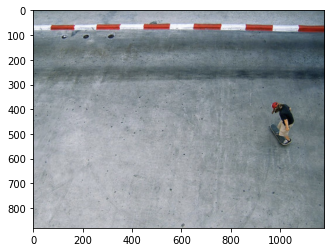

In [268]:
model = vgg1
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little girl is rolling out of the white dog that is floating outside endseq


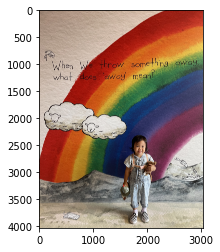

In [221]:
model = vgg1
path = os.path.join(RAND_DIR, "rainbow.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little girl is rolling out of the white dog that is being held by his reflection endseq


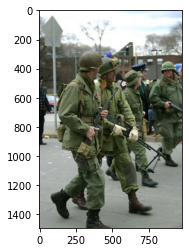

In [222]:
model = vgg1
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little boy is carrying ball through the air endseq


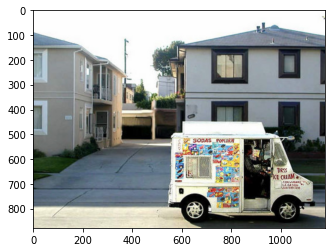

In [223]:
model = vgg1
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the dog is standing under the bear that has its hair wide open endseq


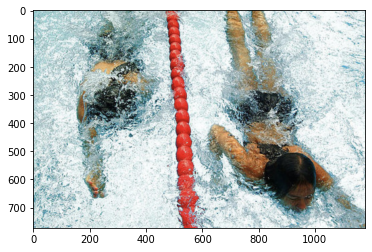

In [224]:
model = vgg1
path = os.path.join(RAND_DIR, "swim.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little girl is rolling out of the white dog that is its face from the tube endseq


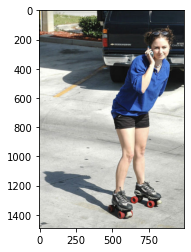

In [225]:
model = vgg1
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little girl is rolling out of the orange car being at the camera endseq


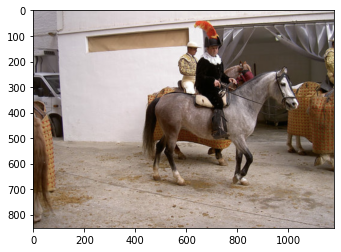

In [226]:
model = vgg1
path = os.path.join(RAND_DIR, "horse.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### VGG16 Base plus Dropout Model

-----------Predicted-----------
startseq two children are playing in the sand endseq


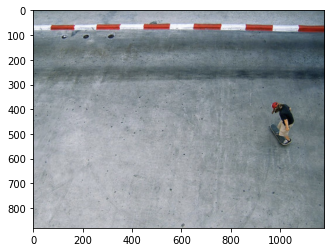

In [227]:
model = vgg2
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq little girl is flying through the air on his bicycle endseq


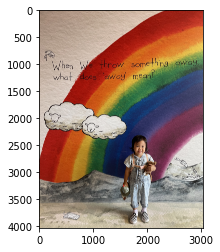

In [228]:
model = vgg2
path = os.path.join(RAND_DIR, "rainbow.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two people are standing on top of rocks with red clouds in the background endseq


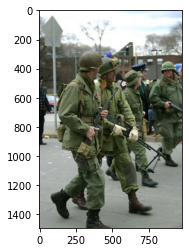

In [229]:
model = vgg2
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two children are playing in the grass endseq


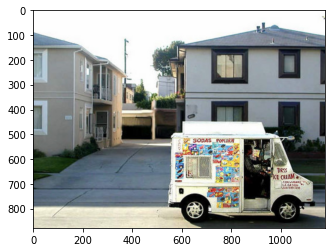

In [230]:
model = vgg2
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq the little boy is walking down the hill endseq


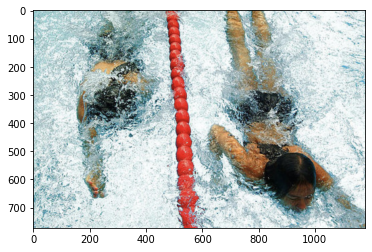

In [231]:
model = vgg2
path = os.path.join(RAND_DIR, "swim.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq boy in red shirt is standing on top of dirt ledge endseq


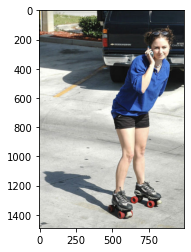

In [232]:
model = vgg2
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two children are playing in the sand endseq


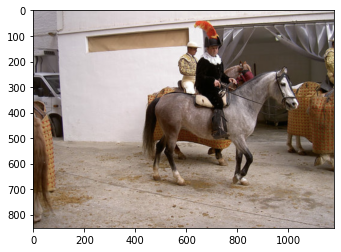

In [233]:
model = vgg2
path = os.path.join(RAND_DIR, "horse.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### VGG16 Base plus Dropout and Kernel Regulariser Model

-----------Predicted-----------
startseq dog is running through the water endseq


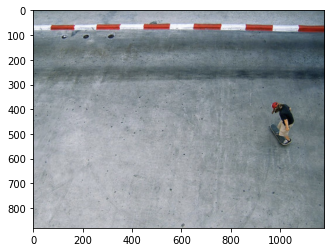

In [234]:
model = vgg3
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the water endseq


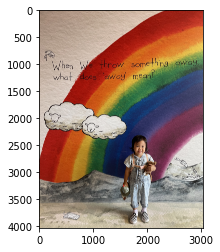

In [235]:
model = vgg3
path = os.path.join(RAND_DIR, "rainbow.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the water endseq


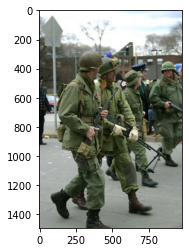

In [236]:
model = vgg3
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in blue shirt is standing in front of brick wall endseq


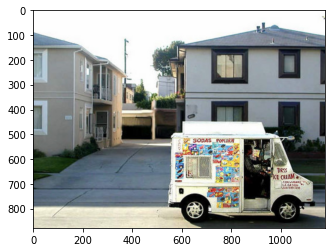

In [237]:
model = vgg3
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the water endseq


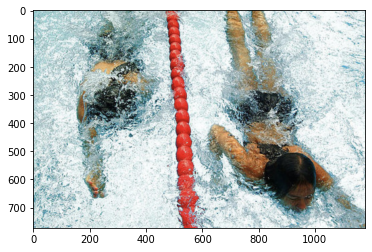

In [238]:
model = vgg3
path = os.path.join(RAND_DIR, "swim.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in blue shirt is standing in front of an orange sculpture endseq


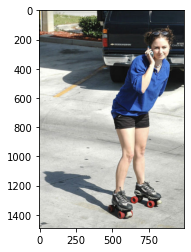

In [239]:
model = vgg3
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq dog is running through the water endseq


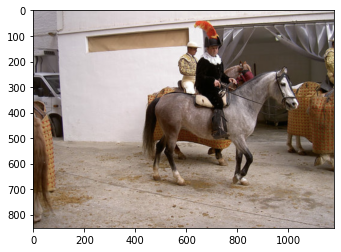

In [240]:
model = vgg3
path = os.path.join(RAND_DIR, "horse.jpg")
image = Image.open(path)
photo = extract_features_vgg(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

## Inception v3 Models

### Inception v3 Base Model

-----------Predicted-----------
startseq skateboarder in black shirt is wearing all black gear and it endseq


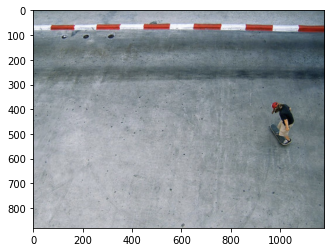

In [243]:
model = inception1
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two children are playing in mud that is wearing shirt endseq


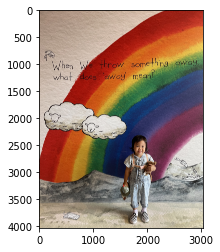

In [244]:
model = inception1
path = os.path.join(RAND_DIR, "rainbow.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in black coat and coat makes his picture enlarged endseq


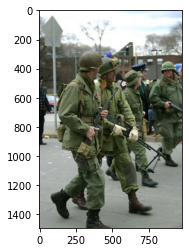

In [245]:
model = inception1
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man and woman wait to cross street endseq


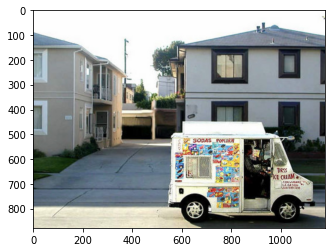

In [246]:
model = inception1
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq three children playing on the floor endseq


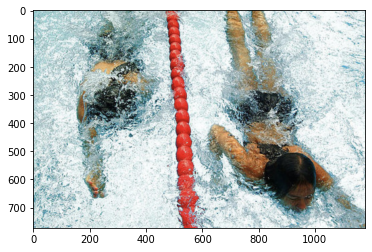

In [247]:
model = inception1
path = os.path.join(RAND_DIR, "swim.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two women are rollerskating one is walking endseq


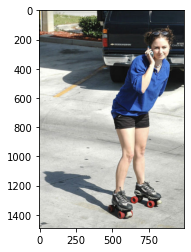

In [248]:
model = inception1
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in white shirt and suit is sitting on horse high up to the camera endseq


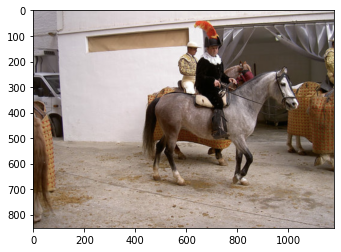

In [249]:
model = inception1
path = os.path.join(RAND_DIR, "horse.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### Inception v3 Base with Dropout Model

-----------Predicted-----------
startseq man in green vest and jeans skateboards down ramp endseq


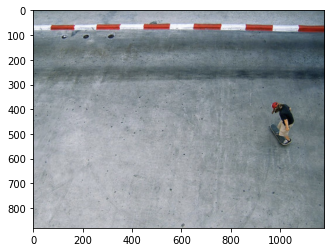

In [250]:
model = inception2
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two young girls htting each other with red school endseq


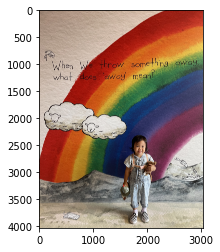

In [251]:
model = inception2
path = os.path.join(RAND_DIR, "rainbow.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq group of people in uniform stand in line endseq


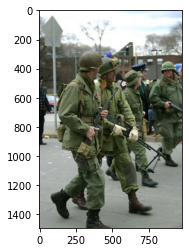

In [252]:
model = inception2
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in blue shirt pushes man in wheelchair on the street endseq


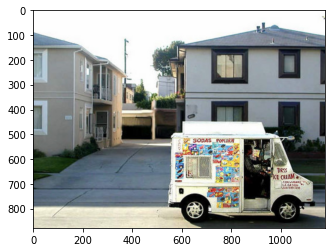

In [253]:
model = inception2
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two children in bathing suits are playing in the melting slush endseq


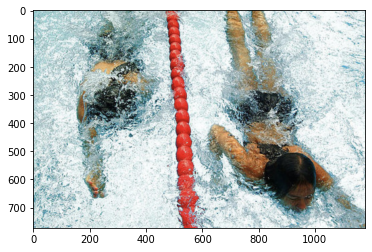

In [254]:
model = inception2
path = os.path.join(RAND_DIR, "swim.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq woman in red shirt and silver shorts is jogging on the sidewalk endseq


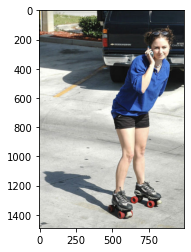

In [255]:
model = inception2
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two young children are riding on grassy path also in the grass endseq


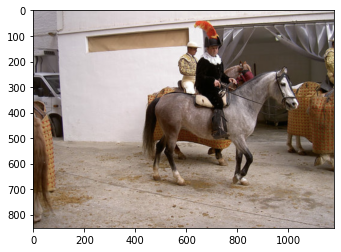

In [256]:
model = inception2
path = os.path.join(RAND_DIR, "horse.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

### Inception v3 Base Model with Dropout and Kernel Regulariser

-----------Predicted-----------
startseq man in black shirt is riding bicycle down the street endseq


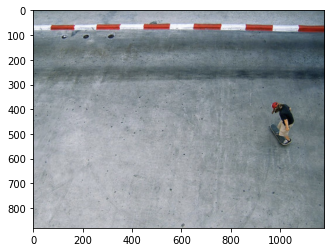

In [257]:
model = inception3
path = os.path.join(RAND_DIR, "skater.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in red shirt is standing in front of large crowd endseq


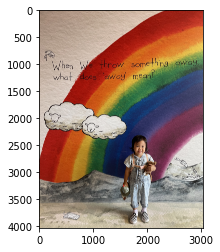

In [258]:
model = inception3
path = os.path.join(RAND_DIR, "rainbow.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq group of people are standing in front of large building displaying their hands endseq


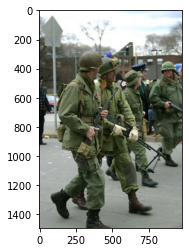

In [259]:
model = inception3
path = os.path.join(RAND_DIR, "soldiers.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in black shirt is standing on the street next to car endseq


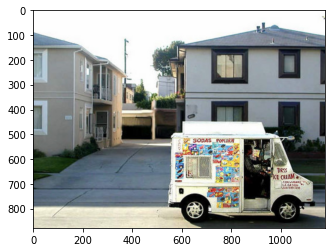

In [260]:
model = inception3
path = os.path.join(RAND_DIR, "van.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man is standing on the shore of the ocean endseq


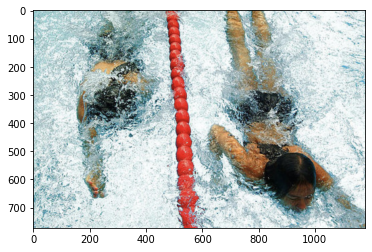

In [261]:
model = inception3
path = os.path.join(RAND_DIR, "swim.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq man in black shirt is standing in front of an art gallery endseq


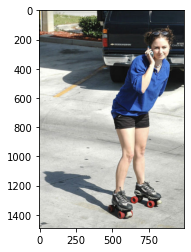

In [262]:
model = inception3
path = os.path.join(RAND_DIR, "rollerskate.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)

-----------Predicted-----------
startseq two dogs are running through the grass endseq


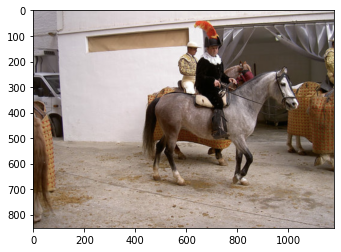

In [263]:
model = inception3
path = os.path.join(RAND_DIR, "horse.jpg")
image = Image.open(path)
photo = extract_features_inception(path)

description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(image)
print('-----------Predicted-----------')
print(description)